# ENCS5341 - Machine Learning  
## Assignment 1: Data Preprocessing & Exploratory Data Analysis (EDA)

## Environment Setup

In [ ]:
!python -m venv .venv
# and then .venv\Scripts\activate in the terminal

## Install all required packages

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Step 1: Data Loading and Initial Inspection:

### Loading the data

In [2]:
data = pd.read_csv("../data/Customer_Data.csv")

### Inspecting first few rows

In [ ]:
data.head()

### Checking general information

In [ ]:
data.info()

### Summary statistics

In [ ]:
data.describe()

## Step 2: Handling Missing Data

### Number of null values in each column

In [ ]:
data.isnull().sum()

### Handling missing values for Age

We did not think using the overall mean for the age is ideal, so we decided to fill missing values using the mean for each gender group separately.

In [3]:
meanAgeFemale = data[data["Gender"] == 1]["Age"].mean()
meanAgeMale = data[data["Gender"] == 0]["Age"].mean()

data.loc[data["Gender"] == 1, "Age"] = data.loc[data["Gender"] == 1, "Age"].fillna(meanAgeFemale)
data.loc[data["Gender"] == 0, "Age"] = data.loc[data["Gender"] == 0, "Age"].fillna(meanAgeMale)

### Handling missing values for SupportCalls
We noticed that the minimum value for SupportCalls is 1, so we assumed that if the value is null it means that no calls were made therefor fill it with zero.

In [4]:
data["SupportCalls"] = data["SupportCalls"].fillna(0)

### Handling missing values for Income 
Filling the missing income values with the median is not sufficient.

So we grouped customers in bins based on their age range and filled the null income values with the median income of each group

In [5]:
bins = [10, 20, 30, 40, 50, 60, 70]
labels = ["10-19", "20-29", "30-39", "40-49", "50-59", "60-69"]
data["GroupByAge"] = pd.cut(data["Age"], bins=bins, labels=labels, right=False)

medianPerGroup = data.groupby("GroupByAge")["Income"].median()

for group in medianPerGroup.index:
    data.loc[(data["GroupByAge"] == group) & (data["Income"].isnull()), "Income"] = medianPerGroup[group]

data.drop("GroupByAge", axis=1, inplace=True)

C:\Users\mass\AppData\Local\Temp\ipykernel_4332\500644253.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medianPerGroup = data.groupby("GroupByAge")["Income"].median()


### Handling missing values for Tenure
We filled the missing values based on Churn status and predefined group ratios

When grouping the data by tenure, we notice two things:

        1. All people who churn have been with the company for less than two years
        2. People who don't churn are split among the three groups, we will fill the missing data according to the existing ratio:
            0-2 -> 0.175
            3-5 -> 0.35
            6-9 -> 0.475

In [6]:
bins = [0, 3, 6, 10]
labels = ['0-2', '3-5', '6-9']

data['TenureGroup'] = pd.cut(data['Tenure'], bins=bins, labels=labels, right=False)
table = pd.crosstab(data['TenureGroup'], data['ChurnStatus'])
data.drop("TenureGroup", axis=1, inplace=True)
table

ChurnStatus,0,1
TenureGroup,,
0-2,557,149
3-5,1113,0
6-9,1506,0


Using the ratios generated below, we can apply the same ratio to the missing values

In [7]:
tenureGroupData = pd.cut(data[(data['ChurnStatus'] == 0) & (data['Tenure'].notnull())]['Tenure'], bins=bins, labels=labels, right=False)
ratios = tenureGroupData.value_counts(normalize=True)
ratios

Tenure
6-9    0.474181
3-5    0.350441
0-2    0.175378
Name: proportion, dtype: float64

In [8]:
for i in data.index:
    if pd.isnull(data.loc[i, "Tenure"]):
        if data.loc[i, "ChurnStatus"] == 1:
            data.loc[i, "Tenure"] = np.random.uniform(0, 2)
        else:
            r = np.random.rand()
            if r < 0.175:
                data.loc[i, "Tenure"] = np.random.uniform(0, 2)
            elif r < 0.35:
                data.loc[i, "Tenure"] = np.random.uniform(3, 5)
            else:
                data.loc[i, "Tenure"] = np.random.uniform(6, 9)

### Number of null values in each column after solving missing values

In [9]:
data.isnull().sum()

CustomerID      0
Age             0
Gender          0
Income          0
Tenure          0
ProductType     0
SupportCalls    0
ChurnStatus     0
dtype: int64

## Step 3: Handling Outliers

### Handling outliers in the Age column.


We will determine whether a customer’s age is an outlier by considering both their Age and Tenure.

In [10]:
outliers = data[data['Age'] - data['Tenure'] <= 15]

print("Count:", len(outliers))

Count: 199


We noticed that there are 199 customers whose Age values were probably entered incorrectly.

To smooth these data, we will generate a random number between 16 and 20 and add it to the Tenure value. The result will be considered as the Age of the customer.

In [11]:
outliers = (data['Age'] - data['Tenure'] <= 15)

randomNumber = np.random.uniform(16, 20, size=outliers.sum())
data.loc[outliers, 'Age'] = data.loc[outliers, 'Tenure'] + randomNumber

outliersAge = data[data['Age'] - data['Tenure'] <= 15]
print("Count:", len(outliersAge))

Count: 0


The number of Age outliers is now zero. All Age values have been corrected.

### Handling outliers in the SupportCalls column.

The following box plot highlight the presence of outliers in the SupportCalls.

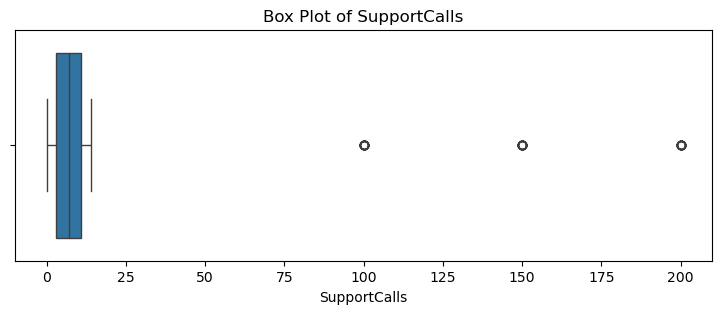

In [12]:
fig, ax = plt.subplots(figsize=(9, 3))

sns.boxplot(data=data, x="SupportCalls", ax=ax)
ax.set_title("Box Plot of SupportCalls")
plt.show()

It's clear that there are outliers in the SupportCalls. We will detect these rows using the Z-score.

In [13]:
z_scores = np.abs(stats.zscore(data['SupportCalls'].dropna()))

outliers_mask = z_scores > 3

print("Number of SupportCalls outliers:", outliers_mask.sum())

Number of SupportCalls outliers: 70


We will resolve these outliers using binning methods with a bin size of 500, where each value in a bin is replaced by the median of that bin. This smooths the data and reduces the impact of extreme values.

In [14]:
data_sorted = data.sort_values('SupportCalls').reset_index(drop=True)

bin_size = 500
n = len(data_sorted)
num_bins = int(np.ceil(n / bin_size))

for i in range(num_bins):
    start = i * bin_size
    end = min((i + 1) * bin_size, n)
    median_value = data_sorted.loc[start:end-1, 'SupportCalls'].median()
    data_sorted.loc[start:end-1, 'SupportCalls'] = median_value

data['SupportCalls'] = data_sorted['SupportCalls']

z_scores = np.abs(stats.zscore(data['SupportCalls'].dropna()))

outliers_mask = z_scores > 3

print("Number of SupportCalls outliers after smoothing:", outliers_mask.sum())

Number of SupportCalls outliers after smoothing: 0


SupportCalls values has been smoothed correctly.

### Handling outliers in the Income column.

The following box plot highlight the presence of outliers in the Income.

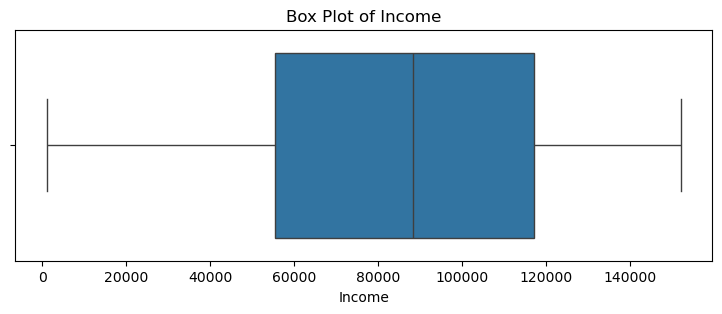

In [20]:
fig, ax = plt.subplots(figsize=(9, 3))

sns.boxplot(data=data, x="Income", ax=ax)
ax.set_title("Box Plot of Income")
plt.show()

It's clear that there are outliers in the Income. We will detect these rows using the Z-score.

In [16]:
z_scores = np.abs(stats.zscore(data['Income'].dropna()))

outliers_mask = z_scores > 3

print("Number of Income outliers:", outliers_mask.sum())

Number of Income outliers: 50


It seems that 50 Income entries were stored in a different unit. To correct this, we will normalize them by dividing each value by 1,000.

In [19]:
outlier_indices = data['Income'].dropna().index[outliers_mask]

data.loc[outlier_indices, 'Income'] = data.loc[outlier_indices, 'Income'] / 1000

z_scores = np.abs(stats.zscore(data['Income'].dropna()))

outliers_mask = z_scores > 3

print("Number of Income outliers after smoothing:", outliers_mask.sum())

Number of Income outliers after smoothing: 0


SupportCalls values has been smoothed correctly.

## Step 4: Feature Scaling

In feature scaling, we chose Z-score scaling for all of the numerical features we have because:
1. It centers data around mean of 0 and a standard deviation of 1. 
2. Keeps the shape and distribution of each feature.
3. Ensures all of the features are equally important for the model training, even if they have different numerical scales.
4. Our values are not naturally bounded and can be considered continuous.

### Visualize distributions before scaling

<Axes: xlabel='SupportCalls', ylabel='Count'>

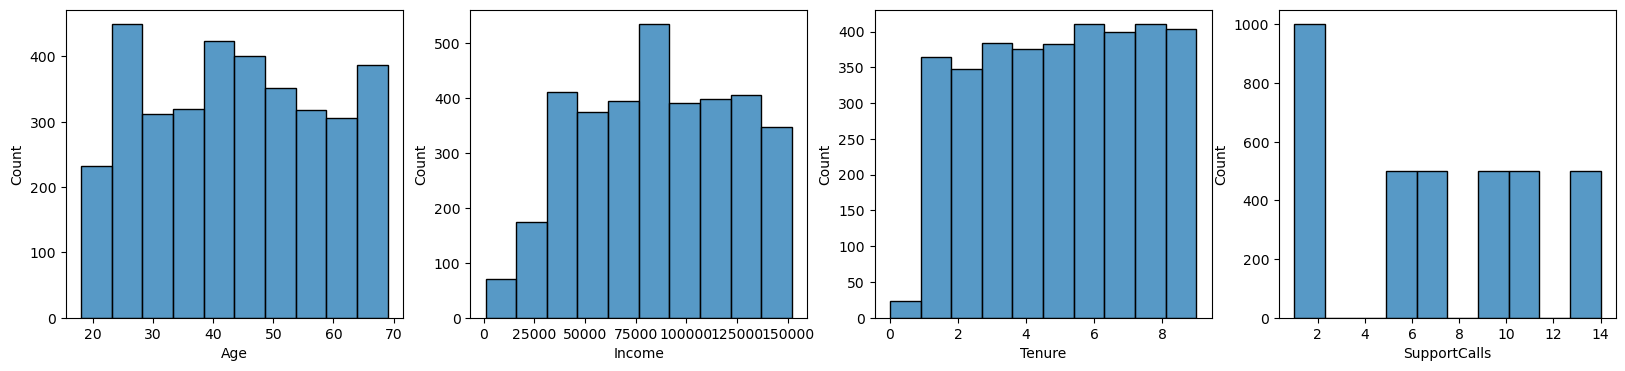

In [21]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=4)
sns.histplot(data=data, x="Age", ax=axs[0], bins=10)
sns.histplot(data=data, x="Income", ax=axs[1], bins=10)
sns.histplot(data=data, x="Tenure", ax=axs[2], bins=10)
sns.histplot(data=data, x="SupportCalls", ax=axs[3], bins=10)

### Apply standardization


In [22]:
scaler = StandardScaler()
data[['Age', 'Income', 'SupportCalls', 'Tenure']] = scaler.fit_transform(data[['Age', 'Income', 'SupportCalls', 'Tenure']])

### Visualize distributions after scaling

<Axes: xlabel='SupportCalls', ylabel='Count'>

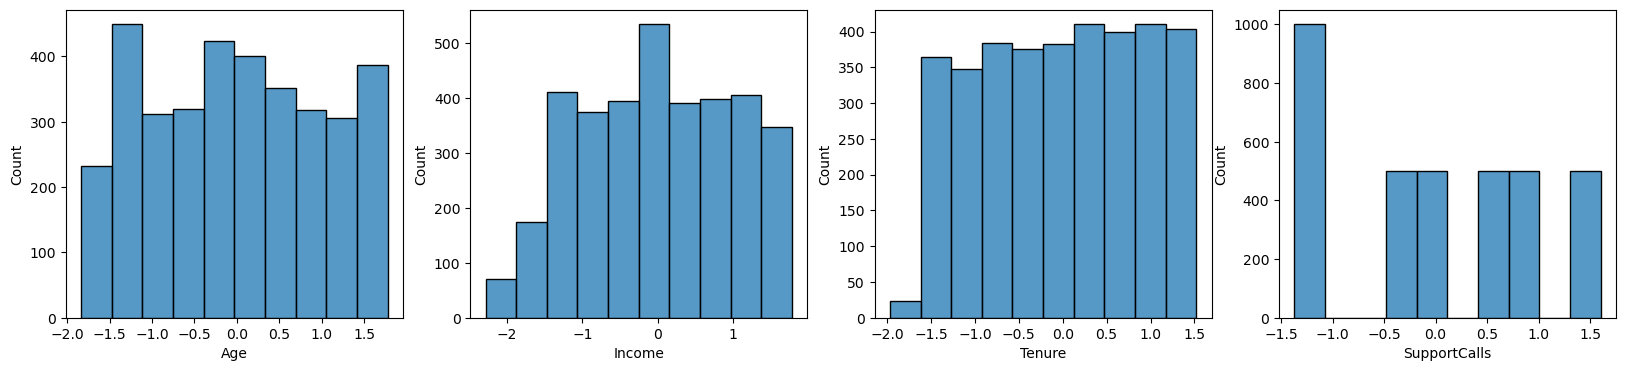

In [23]:
fig, axs = plt.subplots(figsize=(20, 4), ncols=4)
sns.histplot(data=data, x="Age", ax=axs[0], bins=10)
sns.histplot(data=data, x="Income", ax=axs[1], bins=10)
sns.histplot(data=data, x="Tenure", ax=axs[2], bins=10)
sns.histplot(data=data, x="SupportCalls", ax=axs[3], bins=10)

## Step 5: Exploratory Data Analysis

### • Univariate Analysis

The following plots are histograms and box plots for all numerical features.

The left column represents the data distribution across different bins.

The right column represents the spread as well as any outliers.

We can make the following remarks based on the plots:

1. For age: the customers are spread uniformly across age distributions with no skew.
2. For income: after removing outliers, the distribution is now more balanced and interpretable, showing the main customer group clearly.
3. For tenure: values are evenly distributed across the full range with no anomalies.
4. For support calls: distribution appears reasonable and concentrated around lower values after removing extreme outliers.

<Axes: ylabel='SupportCalls'>

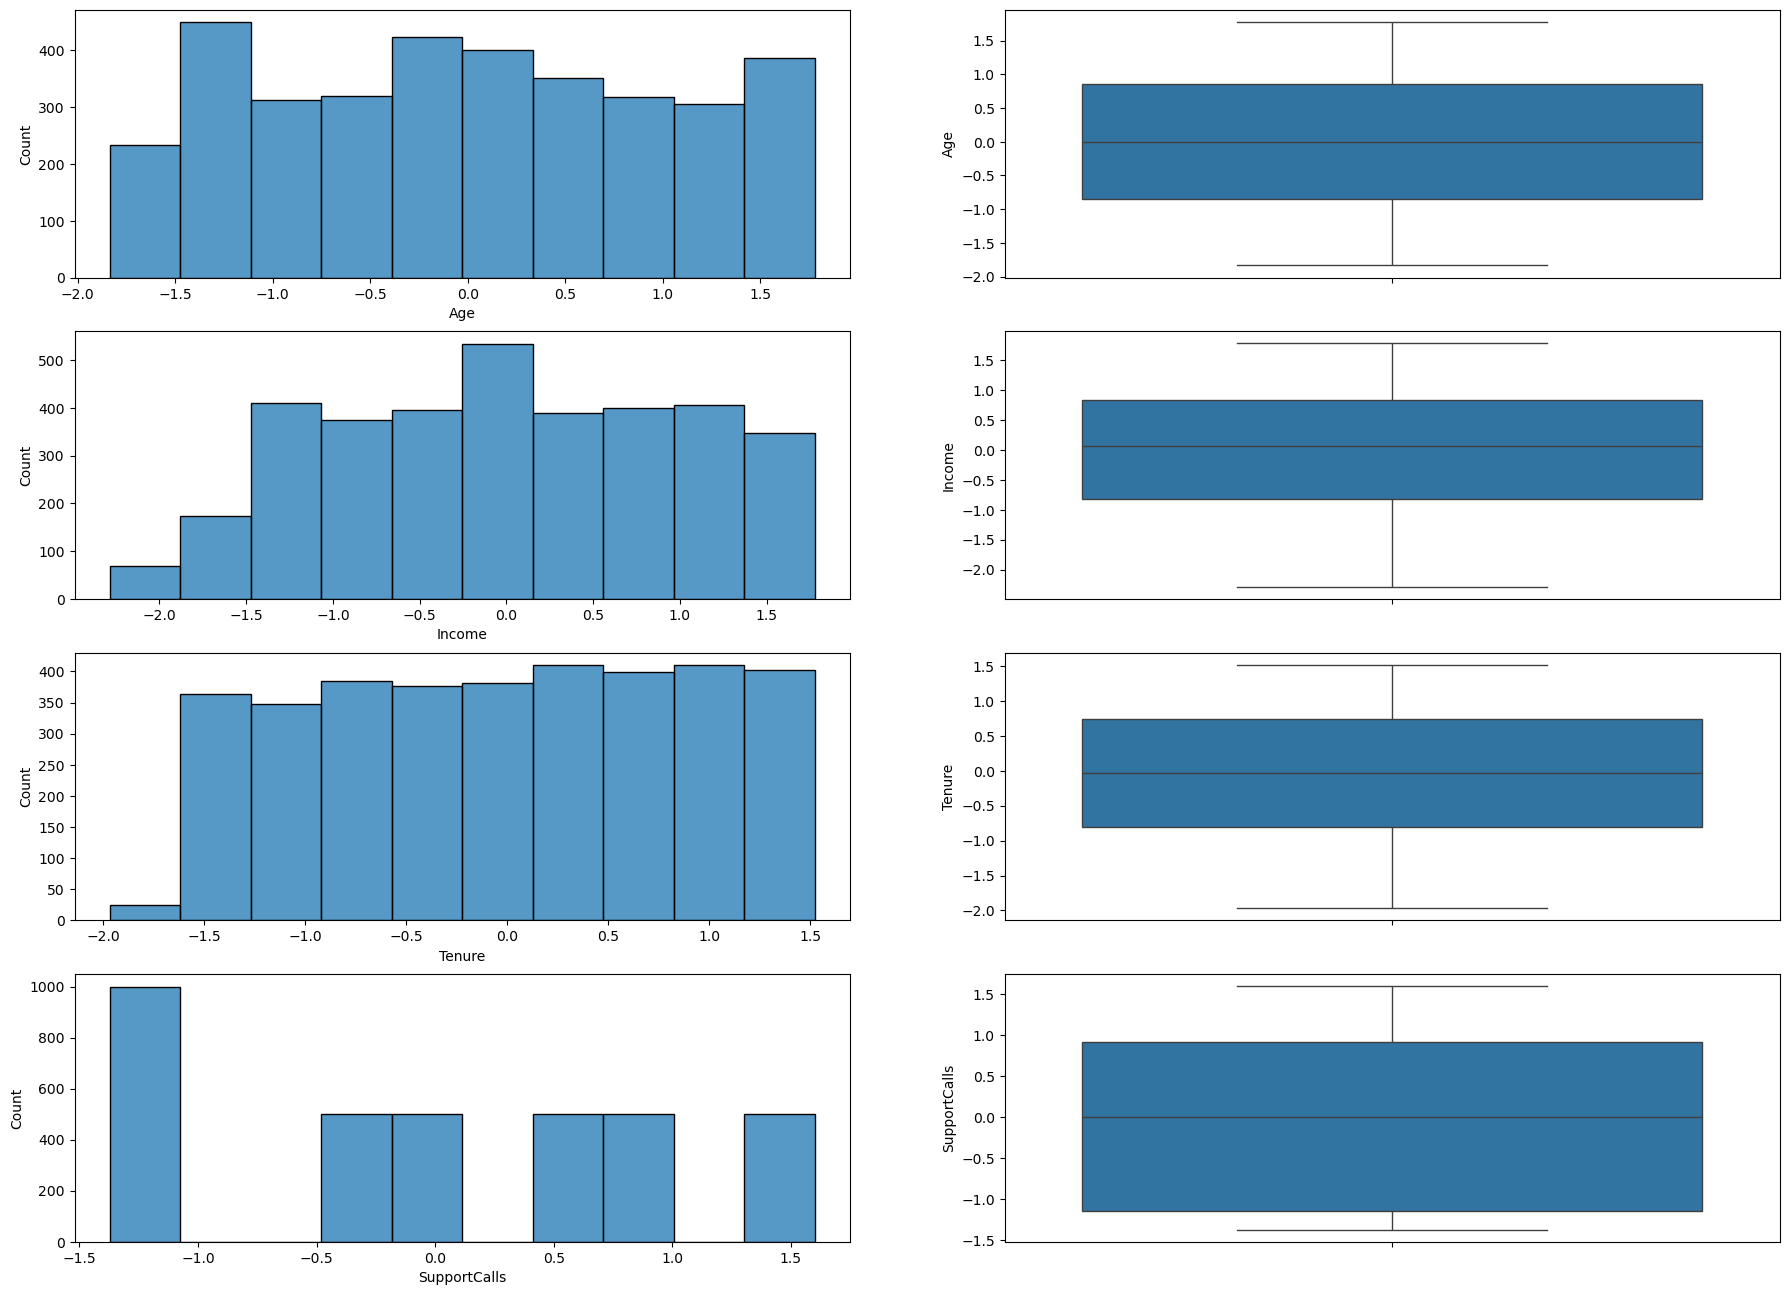

In [24]:
fig, axs = plt.subplots(figsize=(22, 16), ncols=2, nrows=4)
sns.histplot(data=data, x="Age", ax=axs[0][0], bins=10)
sns.boxplot(data=data, y="Age",ax=axs[0][1])

sns.histplot(data=data, x="Income", ax=axs[1][0], bins=10)
sns.boxplot(data=data, y="Income",ax=axs[1][1])

sns.histplot(data=data, x="Tenure", ax=axs[2][0], bins=10)
sns.boxplot(data=data, y="Tenure",ax=axs[2][1])

sns.histplot(data=data, x="SupportCalls", ax=axs[3][0], bins=10)
sns.boxplot(data=data, y="SupportCalls",ax=axs[3][1])

The following plot shows the distribution of age values separated by gender.

The overlapping bars show how both genders are spread across the age ranges, the colored tips represent which gender occurs more in that age range.

<Axes: xlabel='Age', ylabel='Count'>

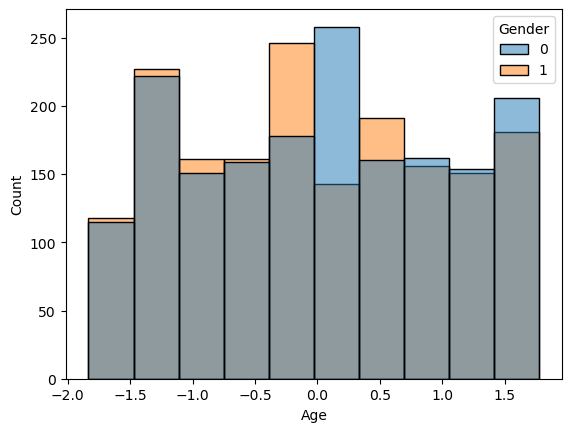

In [25]:
sns.histplot(data=data, x="Age", hue="Gender", bins=10)

The following bar plots visualize the distribution for all categorical values.

We can make the following remarks based on the plots:

1. For gender: the data is very balanced meaning there is no bias in the distribution.
2. For churn status: the data is not balanced as barely any customers churn compared to the customers who stay.
2. For product type: almost half of the customers go for the premium product rather than the basic. 

<Axes: xlabel='ProductType', ylabel='count'>

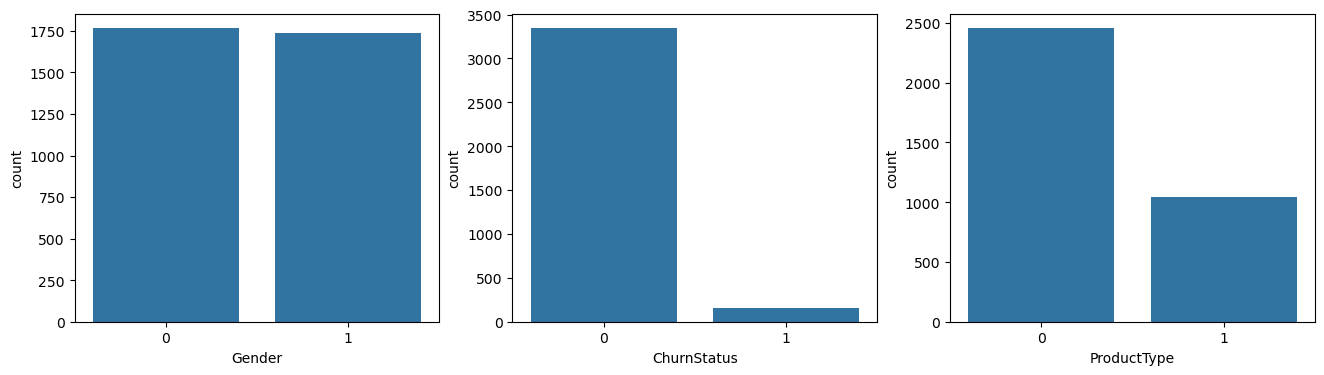

In [26]:
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
sns.countplot(data=data, x="Gender", ax=axs[0])
sns.countplot(data=data, x="ChurnStatus", ax=axs[1])
sns.countplot(data=data, x="ProductType", ax=axs[2])

### • Bivariate Analysis

The following scatter plot shows the relationship between Age and Income and the points are colored by ChurnStatus.

With the outliers already removed, the relationship between the Income and ChurnStatus becomes clear as no customer with an income higher than 50k has churned across all ages.

Text(0.5, 1.0, 'Age vs Income colored by ChurnStatus')

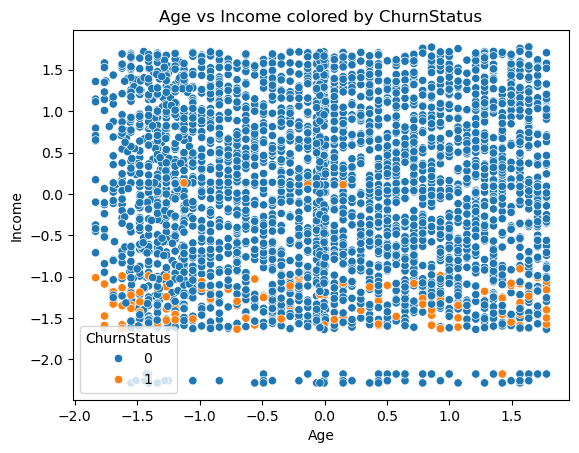

In [40]:
sns.scatterplot(x="Age", y='Income', hue='ChurnStatus', data=data)
plt.title(f"Age vs Income colored by ChurnStatus")

The following plot shows how customers who stayed or churned are distributed across different tenure and income values.

The result comes as no surprise as we already learned the relationship between Tenure and Churn as well as the relationship between Tenure and Income, so this plot is a mix of those.

Text(0.5, 1.0, 'Tenure vs Income colored by ChurnStatus')

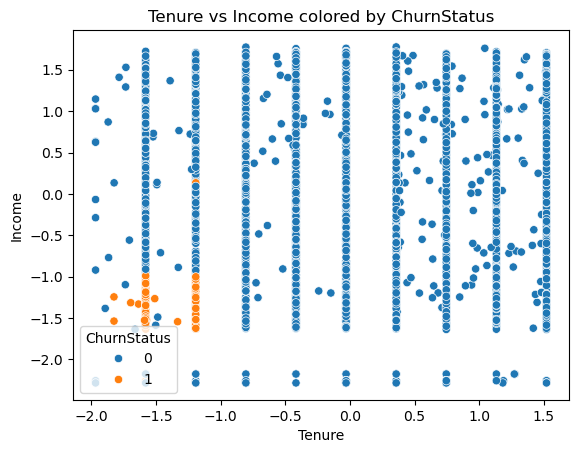

In [28]:

sns.scatterplot(x="Tenure", y='Income', hue='ChurnStatus', data=data)
plt.title(f"Tenure vs Income colored by ChurnStatus")

This plot still shows no meaningful pattern between SupportCalls and Income, even after outlier removal, ChurnStatus appears unrelated to these two features.

Text(0.5, 1.0, 'SupportCalls vs Income colored by ChurnStatus')

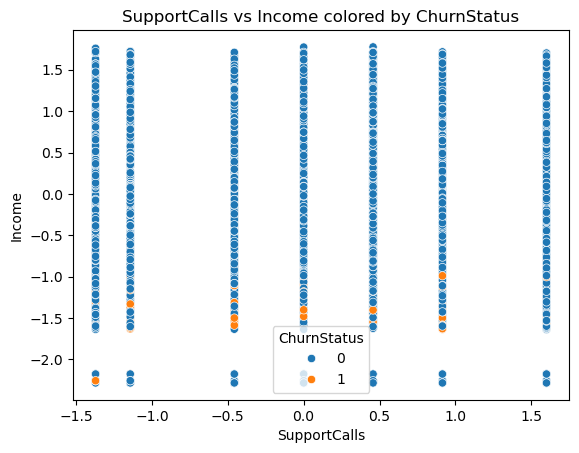

In [29]:
sns.scatterplot(x="SupportCalls", y='Income', hue='ChurnStatus', data=data)
plt.title(f"SupportCalls vs Income colored by ChurnStatus")

The following box plots show the relationship between numerical features and ChurnStatus.

The plots shows that customers who churn have lower tenure and lower income.

<Axes: xlabel='ChurnStatus', ylabel='SupportCalls'>

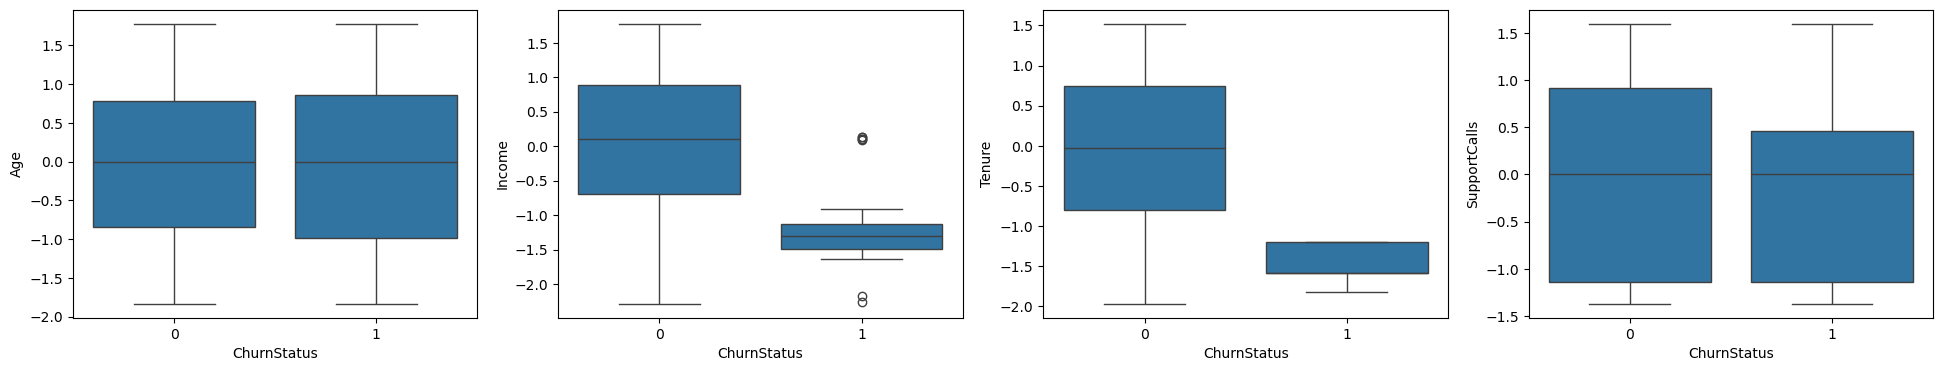

In [30]:
fig, axs = plt.subplots(figsize=(24, 4), ncols=4)
sns.boxplot(x="ChurnStatus", y="Age", data=data, ax=axs[0])
sns.boxplot(x="ChurnStatus", y="Income", data=data, ax=axs[1])
sns.boxplot(x="ChurnStatus", y="Tenure", data=data, ax=axs[2])
sns.boxplot(x="ChurnStatus", y="SupportCalls", data=data, ax=axs[3])

The following count plots show how Gender and ProductType relate to the ChurnStatus.

Since the churn ratio appears similar for customers who churned or who leaved in both categories, we can conclude that Gender and ProductType play no part in predicting churn status.

<Axes: xlabel='ProductType', ylabel='count'>

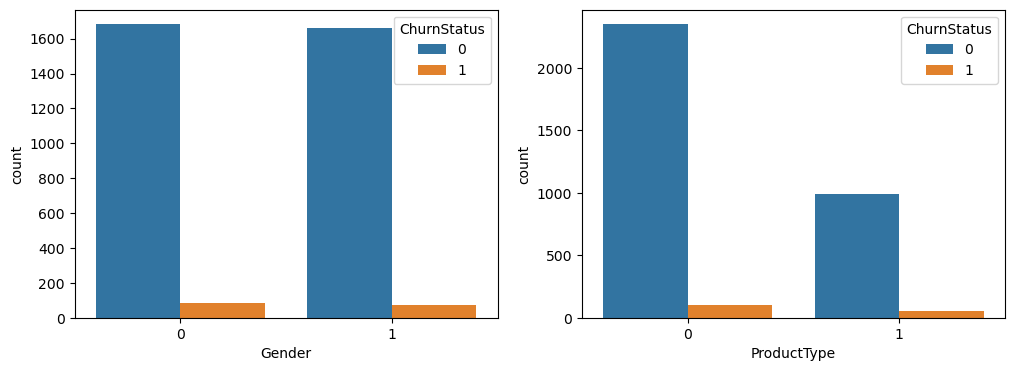

In [31]:
fig, axs = plt.subplots(figsize=(12, 4), ncols=2)
sns.countplot(x='Gender', hue='ChurnStatus', data=data, ax=axs[0])
sns.countplot(x='ProductType', hue='ChurnStatus', data=data, ax=axs[1])

### • Correlation Analysis

We can conclude from the following heatmap that the correlation between Tenure and the target is the strongest and we can split the data to two categorizes:

1. Customers who have been with the company longer tend to stay.
2. New customers are possible to churn.

Other features do not affect the target feature as their correlations are close to 0, showing that they have weak affect on churn in this data.

Text(0.5, 1.0, 'Correlation Heatmap')

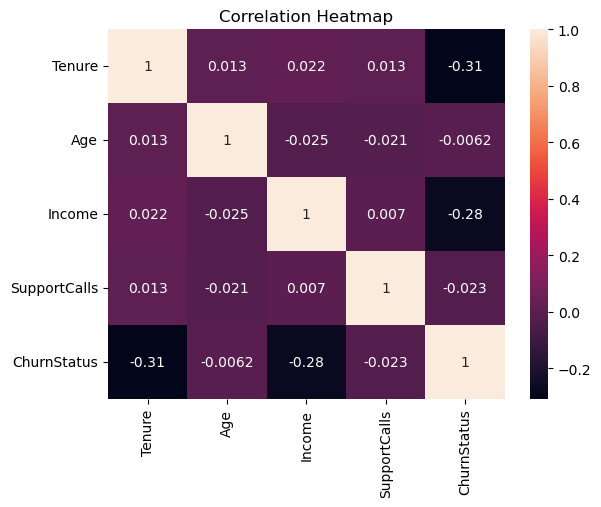

In [32]:
sns.heatmap(data[['Tenure', 'Age', 'Income', 'SupportCalls', 'ChurnStatus']].corr(), annot=True)
plt.title('Correlation Heatmap')

## Step 6: Data Visualization

The following plot describe the correlation between Income and ChurnStatus.

Text(0.5, 1.0, 'Age vs Income colored by ChurnStatus')

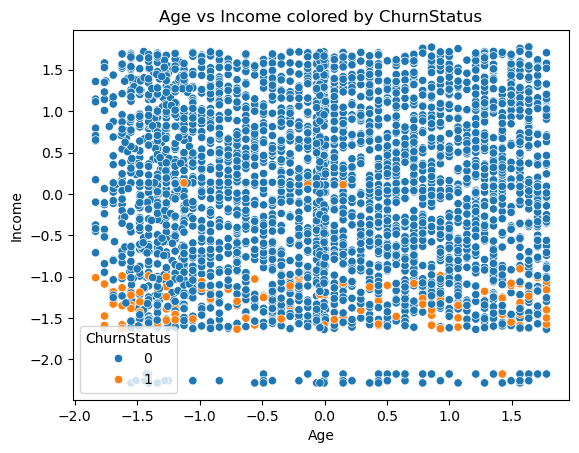

In [41]:
sns.scatterplot(x="Age", y='Income', hue='ChurnStatus', data=data)
plt.title(f"Age vs Income colored by ChurnStatus")

It is clear that customers with higher incomes are less likely to churn, while those with lower incomes are more likely to churn. It is also clear that the age of the customer is not related to churn status.


The following plot shows the correlation between Tenure and ChurnStatus.

Text(0.5, 1.0, 'Age vs Income colored by ChurnStatus')

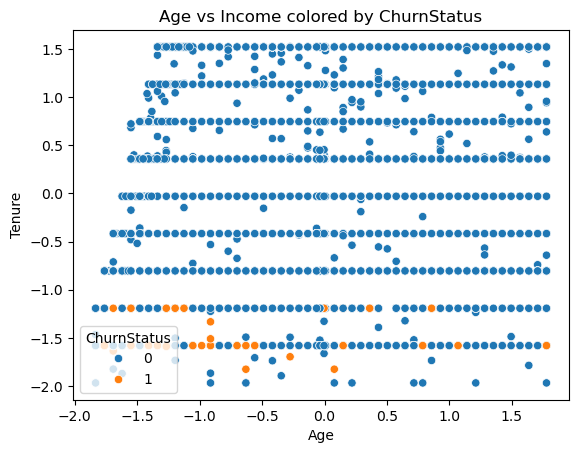

In [45]:
sns.scatterplot(x="Age", y='Tenure', hue='ChurnStatus', data=data)
plt.title(f"Age vs Income colored by ChurnStatus")

The plot shows that customers with higher tenure are less likely to churn, while those with lower tenure may or may not churn. In addition, customers with both lower age and lower tenure are more likely to churn compared to those with higher age or longer tenure.

## Step 7:  Ending Remarks

- The dataset was successfully cleaned and all missing values were handled.
- Outliers were checked for each feature and were detected in *Income*, *Age*, and *SupportCalls*.
- **Tenure** has the strongest correlation and affect on whether a customers churns or stays. 
    - Customers who stay for the first two years, do not churn.
- **Income** also has an influence on the likelihood of churning.
    - Customers who make more than 50k do not churn.
- **Gender**, **ProductType** and **Age** have little effect on churn.